# **MOUNT THE DRIVE**

In [3]:
import os
from google.colab import drive

# 1. Unmount the drive if it's already mounted (optional, but good practice)
# if os.path.isdir('/content/drive'):
#     drive.flush_and_unmount()

# 2. Forcibly remove the existing directory (this is the key fix)
# The '-rf' flag means recursively (r) and forcibly (f) delete the directory and its contents.
!rm -rf /content/drive

# 3. Remount the drive
drive.mount('/content/drive', force_remount=True)

rm: cannot remove '/content/drive/MyDrive': Operation canceled
rm: cannot remove '/content/drive/.shortcut-targets-by-id': Operation canceled
rm: cannot remove '/content/drive/.Trash-0': Directory not empty
rm: cannot remove '/content/drive/.Encrypted/MyDrive': Operation canceled
rm: cannot remove '/content/drive/.Encrypted/.shortcut-targets-by-id': Operation canceled
Mounted at /content/drive


# **Load the ResNet50 and visualizations**

#***************************************************************************

Attempting to analyze image: /content/drive/MyDrive/celeba_models/frame_0006.jpg

--- Loading Custom ResNet50 Checkpoint from: /content/drive/MyDrive/celeba_models/resnet50_quick.pt ---
✅ ResNet50 loaded successfully.

--- Initializing VLM Models (BLIP & CLIP) ---
✅ VLM models loaded successfully.
--- Running VLM and Concept Analysis ---

                 ADVANCED DEEPFAKE ANALYSIS REPORT (ResNet50 + VLM)                   
| ResNet50 Prediction: FAKE | Confidence: 99.47% | Opposing Conf: 0.53%
------------------------------------------------------------------------------------------
| **High-Level Causal Reasoning (CLIP):**
| - **Best Causal Match:** 'eyes look asymmetric' (Score: 0.4941)
| - **Original Image Caption (BLIP):** "a man sitting on a couch in a living room"
------------------------------------------------------------------------------------------
| **Top Concept-Level Explainability (CLIP Similarity):**
| - 0.4219 → 'blurry edges or low-resolution details'
| - 0.2872 → 'u

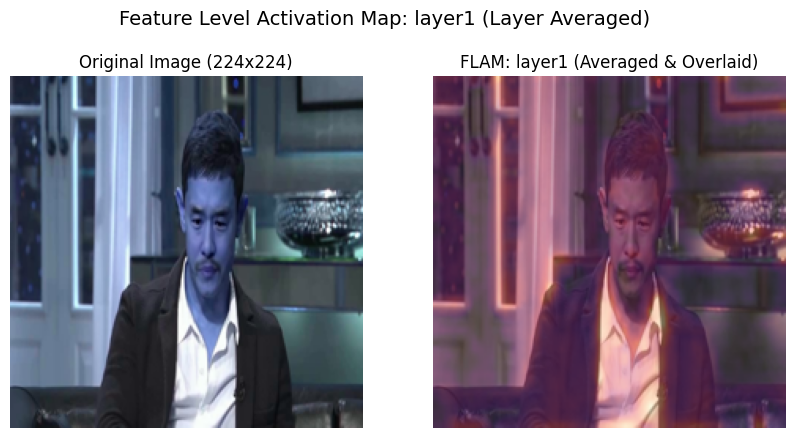

Displayed averaged FLAM visualization for: layer1.


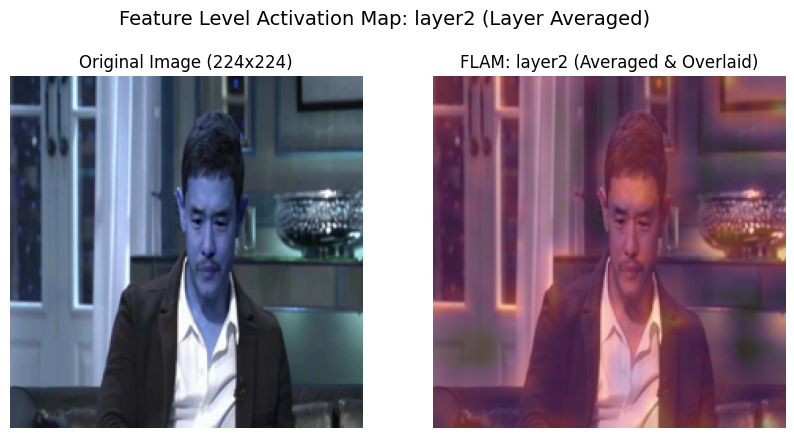

Displayed averaged FLAM visualization for: layer2.


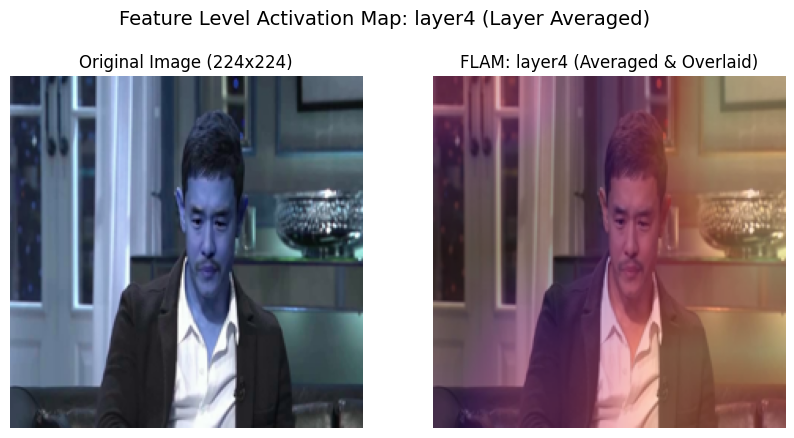

Displayed averaged FLAM visualization for: layer4.

--- Visualizing Feature-Level Activation Maps (FLAM - Individual Filters) ---


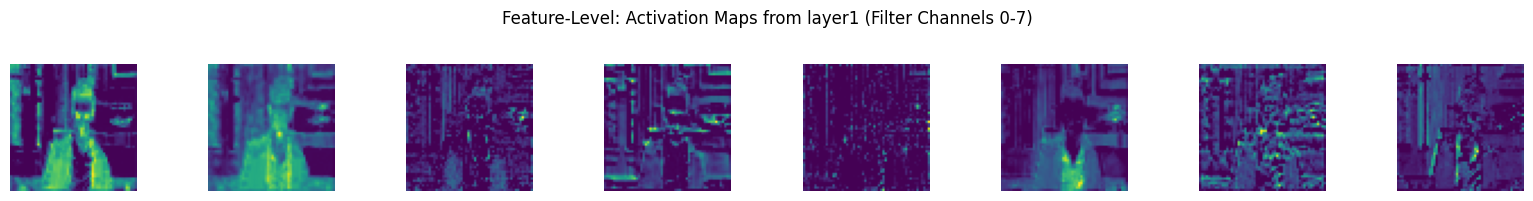

Displayed detailed FLAM visualization for: layer1 showing 8 filters.


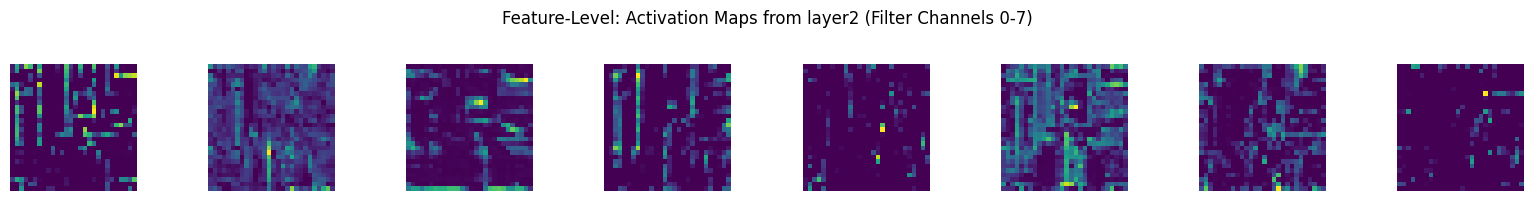

Displayed detailed FLAM visualization for: layer2 showing 8 filters.


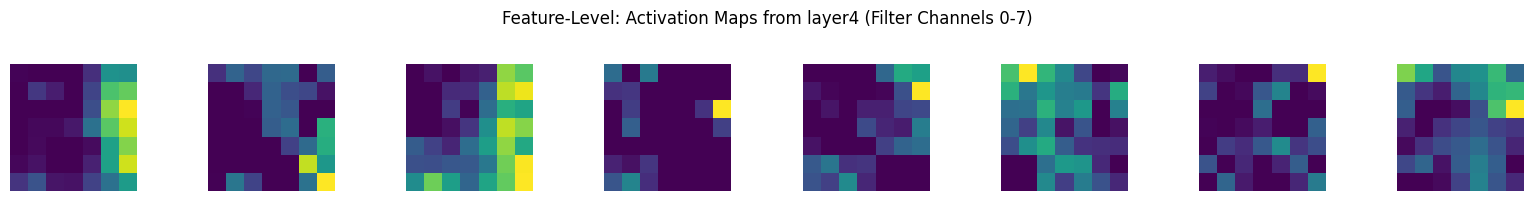

Displayed detailed FLAM visualization for: layer4 showing 8 filters.

--- Visualizing Concept-Level Explainability (CLIP) ---


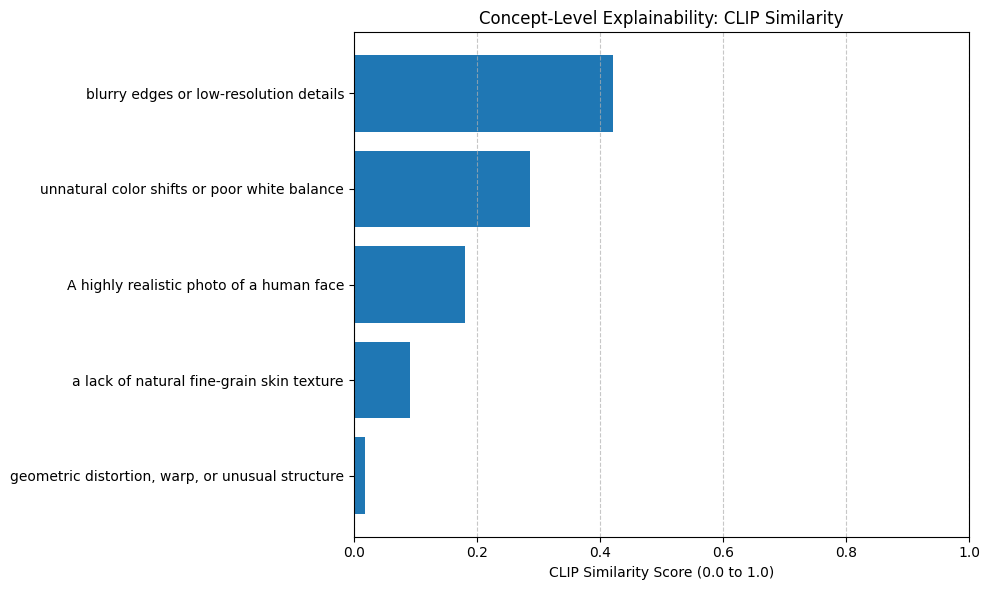

Displayed CLIP Concept Score Visualization.
--- Generating Pixel-Level Importance Maps (Grad-CAM, Guided Backprop) ---

--- Loading Custom ResNet50 Checkpoint from: /content/drive/MyDrive/celeba_models/resnet50_quick.pt ---
✅ ResNet50 loaded successfully.


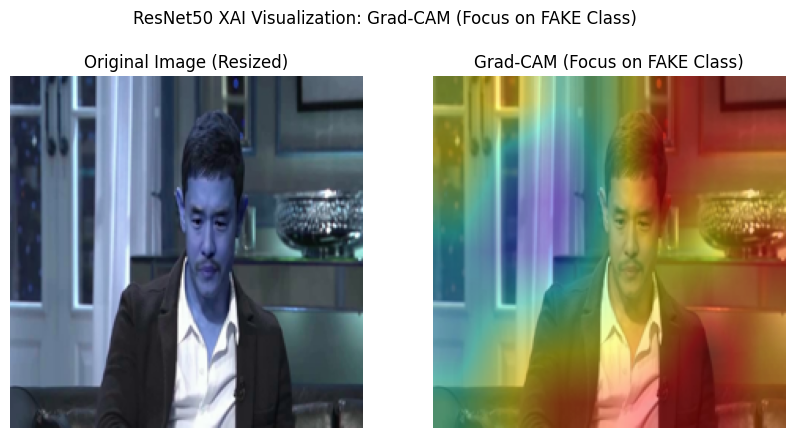

Displayed Pixel Importance map: Grad-CAM (Focus on FAKE Class)


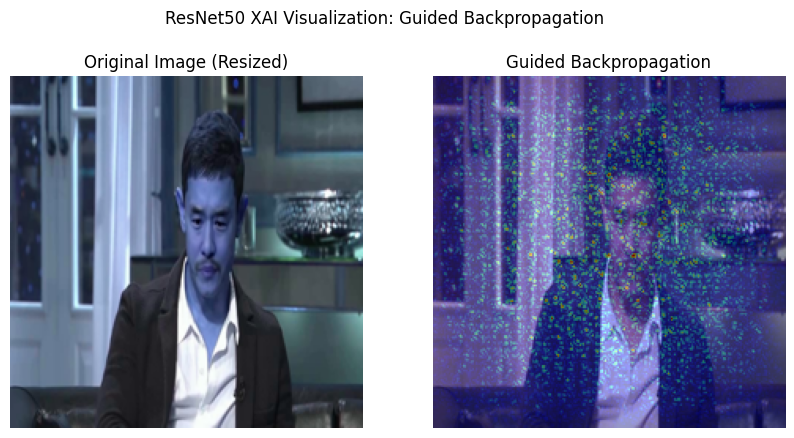

Displayed Pixel Importance map: Guided Backpropagation

Pipeline execution finished. All visualizations are displayed inline.


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import gc
import warnings

# Suppress Hugging Face and Matplotlib warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Attempt to import VLM components
try:
    from transformers import BlipProcessor, BlipForConditionalGeneration, CLIPProcessor, CLIPModel
    VLM_AVAILABLE = True
except ImportError:
    VLM_AVAILABLE = False
    print("Warning: 'transformers' library not found. VLM analysis will be disabled.")


# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define paths (Using the uploaded image file name)
# NOTE: Update these paths in your Colab notebook if they are different!
INPUT_IMAGE_PATH ="/content/drive/MyDrive/celeba_models/frame_0006.jpg"
RESNET_MODEL_PATH = "/content/drive/MyDrive/celeba_models/resnet50_quick.pt"

# Global model and processor instances
blip_processor, blip_model = None, None
clip_processor, clip_model = None, None
resnet_model = None

# ----------------------------------------------------------------------
# 1. VISION-LANGUAGE MODEL (VLM) INTEGRATION & CONCEPT EXPLAINABILITY
# ----------------------------------------------------------------------

def initialize_vlm_models(device):
    """Initializes BLIP and CLIP models."""
    global blip_processor, blip_model, clip_processor, clip_model
    if not VLM_AVAILABLE:
        return False

    print("\n--- Initializing VLM Models (BLIP & CLIP) ---")
    try:
        # 1. BLIP (Captioning)
        blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
        blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

        # 2. CLIP (Zero-Shot Reasoning / Similarity)
        clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
        print("✅ VLM models loaded successfully.")
        return True
    except Exception as e:
        print(f"❌ VLM initialization failed: {e}. VLM analysis disabled.")
        return False

def vision_language_explain(img: Image.Image, device: torch.device):
    """
    Performs VLM analysis, including causal reasoning and concept scoring.

    Returns: (description, best_reasoning, vlm_reason_score, top_concepts_scores)
    """
    if not (blip_model and clip_model):
        return "VLM N/A", "VLM Models Not Ready", 0.0, [], []

    print("--- Running VLM and Concept Analysis ---")
    with torch.no_grad():
        # --- 1. BLIP Captioning ---
        inputs = blip_processor(images=img, return_tensors="pt").to(device)
        caption_ids = blip_model.generate(**inputs, max_new_tokens=40)
        description = blip_processor.batch_decode(caption_ids, skip_special_tokens=True)[0]

        # --- 2. CLIP Causal Reasoning (High-Level) ---
        reasoning_prompts = [
            "a real human face photo",
            "a fake or AI-generated face",
            "eyes look asymmetric",
            "skin has inconsistent texture",
            "lighting and shadows look artificial",
            "face boundary appears blurred"
        ]
        tokens_reason = clip_processor(text=reasoning_prompts, images=img, return_tensors="pt", padding=True).to(device)
        outputs_reason = clip_model(**tokens_reason)
        probs_reason = outputs_reason.logits_per_image.softmax(dim=1).squeeze(0)
        best_prompt_idx = probs_reason.argmax().item()
        best_reasoning = reasoning_prompts[best_prompt_idx]
        best_score_reason = probs_reason[best_prompt_idx].item()

        # --- 3. CLIP Concept Similarity (TCAV Approximation) ---
        # NOTE: This uses the full set of concepts for the bar chart visualization
        concept_prompts_full = [
            "A face with blurry edges or low-resolution details",
            "An image with a lack of natural fine-grain skin texture",
            "A face with unnatural color shifts or poor white balance",
            "A face with geometric distortion, warp, or unusual structure",
            "A highly realistic photo of a human face" # Counter-concept
        ]
        tokens_concept = clip_processor(text=concept_prompts_full, images=img, return_tensors="pt", padding=True).to(device)
        outputs_concept = clip_model(**tokens_concept)
        probs_concept = outputs_concept.logits_per_image.softmax(dim=1).squeeze(0)

        # Pair concepts with all scores for visualization
        all_concepts_scores = [(concept_prompts_full[i], probs_concept[i].item()) for i in range(len(concept_prompts_full))]

        # Only keep top 3 for text summary printing
        top_concepts_summary = sorted(all_concepts_scores, key=lambda x: x[1], reverse=True)[:3]

        return description, best_reasoning, best_score_reason, all_concepts_scores, top_concepts_summary

# ----------------------------------------------------------------------
# 2. RESNET50 & XAI COMPONENTS
# ----------------------------------------------------------------------

def load_resnet_model(model_path: str, device: torch.device):
    """Loads the custom ResNet50 model checkpoint."""
    global resnet_model
    # Ensure a fresh model instance if we are reloading for hooks
    resnet_model = resnet50(weights=None)
    num_ftrs = resnet_model.fc.in_features
    # Assuming 2 classes: FAKE (0) and REAL (1)
    resnet_model.fc = nn.Linear(num_ftrs, 2)

    # Target layers for Grad-CAM and FLAM
    target_layer = "layer4"
    # Use layer names matching the ResNet50 architecture for feature extraction
    flam_layers = ["layer1", "layer2", "layer4"]

    print(f"\n--- Loading Custom ResNet50 Checkpoint from: {model_path} ---")
    try:
        resnet_model.load_state_dict(torch.load(model_path, map_location=device))
        print("✅ ResNet50 loaded successfully.")
    except FileNotFoundError:
        print(f"❌ Error: ResNet50 checkpoint not found at {model_path}. Cannot proceed.")
        return None, None, None
    except Exception as e:
        print(f"❌ Error loading ResNet50 model: {e}")
        return None, None, None

    resnet_model.eval().to(device)
    return resnet_model, target_layer, flam_layers

# --- Guided Backpropagation Implementation ---

# Hook to enforce Guided Backpropagation (only positive gradients pass backward)
def relu_backward_hook(module, grad_input, grad_output):
    """Overrides ReLU backward to implement Guided Backpropagation."""
    # grad_output[0] is the gradient passed back to the input
    return (torch.clamp(grad_output[0], min=0.0),)

class GuidedBackprop:
    """Computes Guided Backpropagation map."""
    def __init__(self, model):
        self.model = model
        self.hooks = []

        # Register hooks on all ReLU modules
        for name, module in self.model.named_modules():
            if isinstance(module, nn.ReLU):
                hook = module.register_backward_hook(relu_backward_hook)
                self.hooks.append(hook)

    def generate(self, input_tensor, class_idx=None):
        input_tensor.grad = None
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        self.model.zero_grad()
        output[0, class_idx].backward()

        # The Guided Backprop map is the gradient w.r.t the input tensor
        guided_map = input_tensor.grad.data.abs().sum(dim=1).squeeze().cpu().numpy()

        # Normalize
        if guided_map.max() > 0:
            guided_map = guided_map / guided_map.max()
        return guided_map

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

# --- Feature Level Activation Maps (FLAM) Implementation ---

class FeatureExtractor:
    """Registers hooks to extract feature maps from specific layers."""
    def __init__(self, model, layers_to_extract):
        self.model = model
        self.features = {}

        for name, module in self.model.named_modules():
            # Check for exact ResNet layer names
            if name in layers_to_extract:
                module.register_forward_hook(self.save_activation(name))

    def save_activation(self, name):
        def hook(module, input, output):
            self.features[name] = output.detach()
        return hook

def visualize_feature_maps_individual(feature_extractor: FeatureExtractor):
    """
    Visualizes individual feature maps (channels) from specific layers,
    displaying the first 8 filters for each layer in a grid. (The detailed view)
    """
    print("\n--- Visualizing Feature-Level Activation Maps (FLAM - Individual Filters) ---")

    FILTERS_TO_SHOW = 8
    LAYER_ORDER = ["layer1", "layer2", "layer4"]

    for layer_name in LAYER_ORDER:
        if layer_name not in feature_extractor.features:
            print(f"Feature map for {layer_name} not found.")
            continue

        features = feature_extractor.features[layer_name]
        # features shape: (1, Channels, Height, Width)
        features_np = features.squeeze(0).cpu().numpy()
        num_channels = features_np.shape[0]
        plots_per_layer = min(FILTERS_TO_SHOW, num_channels)

        fig, axes = plt.subplots(1, plots_per_layer, figsize=(2 * plots_per_layer, 2))

        if plots_per_layer == 1:
            axes = [axes]

        for i in range(plots_per_layer):
            feature_map = features_np[i]

            # Normalize map to (0, 1) range for consistent visualization
            if feature_map.max() > feature_map.min():
                normalized_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())
            else:
                normalized_map = feature_map * 0

            axes[i].imshow(normalized_map, cmap='viridis')
            axes[i].axis('off')

        fig.suptitle(f"Feature-Level: Activation Maps from {layer_name} (Filter Channels 0-{plots_per_layer-1})", fontsize=12)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
        print(f"Displayed detailed FLAM visualization for: {layer_name} showing {plots_per_layer} filters.")
        plt.close(fig)

def visualize_feature_maps_averaged(original_img: Image.Image, feature_extractor: FeatureExtractor):
    """
    Visualizes the average activation map across all channels for layers L1, L2, L4,
    overlaid on the original image. (The high-level view for all relevant layers)
    """
    print("\n--- Visualizing Feature-Level Activation Maps (FLAM - Layer Averaged) ---")

    LAYER_ORDER = ["layer1", "layer2", "layer4"]

    for TARGET_LAYER in LAYER_ORDER:
        if TARGET_LAYER not in feature_extractor.features:
            print(f"Averaged FLAM map for {TARGET_LAYER} not found.")
            continue

        features = feature_extractor.features[TARGET_LAYER].squeeze(0).cpu().numpy()

        # 1. Average across all channels
        averaged_map = np.mean(features, axis=0)

        # 2. Normalize to (0, 1) range
        if averaged_map.max() > averaged_map.min():
            normalized_map = (averaged_map - averaged_map.min()) / (averaged_map.max() - averaged_map.min())
        else:
            normalized_map = averaged_map * 0

        # 3. Use OpenCV to resize and colormap the heatmap
        # Resize to 224x224 for consistent visualization with feature map resolution
        img_cv = cv2.cvtColor(np.array(original_img.resize((224, 224))), cv2.COLOR_RGB2BGR)
        heatmap_resized = cv2.resize(normalized_map, (img_cv.shape[1], img_cv.shape[0]), interpolation=cv2.INTER_LINEAR)

        # Convert heatmap to a colored image using MAGMA or PLASMA for activation maps
        heatmap_colored = np.uint8(255 * heatmap_resized)
        heatmap_colored = cv2.applyColorMap(heatmap_colored, cv2.COLORMAP_MAGMA)

        # 4. Blend the heatmap and the original image
        superimposed = cv2.addWeighted(img_cv, 0.6, heatmap_colored, 0.4, 0)

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        # Display the 224x224 version for consistency in the plot
        plt.imshow(cv2.cvtColor(np.array(original_img.resize((224, 224))), cv2.COLOR_BGR2RGB))
        plt.title("Original Image (224x224)")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        # The superimposed image is in BGR, convert back to RGB for matplotlib
        plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB))
        plt.title(f"FLAM: {TARGET_LAYER} (Averaged & Overlaid)")
        plt.axis('off')

        plt.suptitle(f"Feature Level Activation Map: {TARGET_LAYER} (Layer Averaged)", fontsize=14)
        plt.show()
        print(f"Displayed averaged FLAM visualization for: {TARGET_LAYER}.")
        plt.close()


# --- Shared XAI Utilities ---

def preprocess_image(img_path: str):
    """Prepares the input tensor for ResNet50 analysis."""
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    try:
        # Load the original image without resizing for the main display
        img = Image.open(img_path).convert('RGB')
    except FileNotFoundError:
        print(f"❌ Error: Input image not found at {img_path}. Execution aborted.")
        raise

    # Input tensor requires grad for XAI methods
    # Apply transformation (which includes resizing to 224x224)
    input_tensor = transform(img).unsqueeze(0).to(DEVICE)
    input_tensor.requires_grad = True
    return img, input_tensor

class GradCAM:
    """Implements the Grad-CAM visualization technique."""
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hooks = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        for name, module in self.model.named_modules():
            if name == self.target_layer:
                self.hooks.append(module.register_forward_hook(forward_hook))
                self.hooks.append(module.register_backward_hook(backward_hook))
                return
        raise ValueError(f"Target layer '{self.target_layer}' not found.")

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            _, pred_class_idx_tensor = output.max(dim=1)
            pred_class_idx = pred_class_idx_tensor.item()
        else:
            pred_class_idx = class_idx

        self.model.zero_grad()
        output[0, pred_class_idx].backward(retain_graph=True)

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        weighted_activations = self.activations.clone()
        for i in range(weighted_activations.shape[1]):
            weighted_activations[:, i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(weighted_activations, dim=1).squeeze()
        heatmap = np.maximum(heatmap.cpu().numpy(), 0)

        if np.max(heatmap) > 0:
            heatmap /= np.max(heatmap)

        return heatmap, pred_class_idx

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

def visualize_heatmap_overlay(original_img: Image.Image, heatmap: np.ndarray, title: str):
    """Overlays a heatmap onto the original image for visualization and shows it inline."""
    # Resize the original image to 224x224 to match the GradCAM output resolution
    original_img_resized = original_img.resize((224, 224))
    img_cv = cv2.cvtColor(np.array(original_img_resized), cv2.COLOR_RGB2BGR)

    # Resize and normalize heatmap for overlay
    heatmap_resized = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))

    # Convert heatmap to a colored image using the JET colormap
    heatmap_colored = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_colored, cv2.COLORMAP_JET)

    # Blend the heatmap and the original image
    superimposed = cv2.addWeighted(img_cv, 0.6, heatmap_colored, 0.4, 0)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(np.array(original_img_resized), cv2.COLOR_BGR2RGB))
    plt.title("Original Image (Resized)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')

    plt.suptitle(f"ResNet50 XAI Visualization: {title}")
    plt.show()
    print(f"Displayed Pixel Importance map: {title}")
    plt.close() # CRITICAL: Close plot to free memory

# --- Concept-Level Visualization ---

def visualize_concept_scores(all_concepts_scores: list):
    """Visualizes the CLIP concept scores in a horizontal bar chart."""
    print("\n--- Visualizing Concept-Level Explainability (CLIP) ---")

    if not all_concepts_scores:
        print("No concept scores to visualize.")
        return

    # Prepare data: Extract names and scores
    concepts = [c.replace("A face with", "").replace("An image with", "").strip() for c, s in all_concepts_scores]
    scores = [s for c, s in all_concepts_scores]

    # Sort data for horizontal bar chart (highest score at the top)
    sorted_data = sorted(zip(concepts, scores), key=lambda x: x[1], reverse=True)
    concepts_sorted = [item[0] for item in sorted_data]
    scores_sorted = [item[1] for item in sorted_data]

    # Reverse again for plt.barh (which plots the first element at the bottom)
    concepts_sorted.reverse()
    scores_sorted.reverse()

    plt.figure(figsize=(10, 6))
    plt.barh(concepts_sorted, scores_sorted, color='#1f77b4')
    plt.xlabel("CLIP Similarity Score (0.0 to 1.0)")
    plt.title("Concept-Level Explainability: CLIP Similarity")
    plt.xlim(0, max(1.0, max(scores_sorted) * 1.1)) # Ensure x-axis goes up to at least 1.0
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    print("Displayed CLIP Concept Score Visualization.")
    plt.close()

# ----------------------------------------------------------------------
# 3. MAIN EXECUTION AND REPORT GENERATION
# ----------------------------------------------------------------------

def run_prediction(model: torch.nn.Module, input_tensor: torch.Tensor):
    """Performs a forward pass and returns the human-readable prediction result."""
    with torch.no_grad():
        output = model(input_tensor.detach().clone())
    probabilities = F.softmax(output, dim=1)
    pred_index = probabilities.argmax(dim=1).item()
    label = "FAKE" if pred_index == 0 else "REAL"
    confidence = probabilities[0, pred_index].item() * 100

    # Get the confidence for the 'opposite' class (for better reporting)
    opposite_index = 1 - pred_index
    opposite_confidence = probabilities[0, opposite_index].item() * 100

    # FIX: Corrected the returned variable name from 'opposite_conf' to 'opposite_confidence'
    return label, confidence, pred_index, opposite_confidence

def run_full_pipeline(image_path: str, model_path: str):
    """Coordinates the classification, VLM analysis, and XAI generation."""

    # --- Step 1: Initialization & Loading ---
    print(f"Attempting to analyze image: {image_path}")
    try:
        # original_img is the full resolution image, input_tensor is the 224x224 tensor
        original_img, input_tensor = preprocess_image(image_path)
    except FileNotFoundError:
        return

    # Load ResNet model once for prediction and XAI
    resnet_model, target_layer, flam_layers = load_resnet_model(model_path, DEVICE)
    if not resnet_model:
        return

    vlm_success = initialize_vlm_models(DEVICE)

    # --- Step 2: ResNet50 Classification ---
    # Need to clone the input tensor to ensure gradient tracking starts fresh for XAI
    input_tensor_clone = input_tensor.detach().clone()
    input_tensor_clone.requires_grad = True

    # FIX: The prediction function returns 'opposite_confidence', not 'opposite_conf'
    pred_label, pred_conf, pred_idx, opposite_confidence = run_prediction(resnet_model, input_tensor_clone)

    # --- Step 3: VLM Causal & Concept Analysis ---
    if vlm_success:
        original_desc, vlm_reason, vlm_score, all_concepts_scores, top_concepts_summary = vision_language_explain(original_img, DEVICE)
    else:
        original_desc, vlm_reason, vlm_score, all_concepts_scores, top_concepts_summary = "VLM N/A", "VLM N/A", 0.0, [], []

    # --- Step 4: Unified Report Generation ---
    print("\n" + "="*90)
    print("                 ADVANCED DEEPFAKE ANALYSIS REPORT (ResNet50 + VLM)                   ")
    print("="*90)

    # ResNet Prediction Block
    # FIX: Used 'opposite_confidence' in the print statement
    print(f"| ResNet50 Prediction: {pred_label} | Confidence: {pred_conf:.2f}% | Opposing Conf: {opposite_confidence:.2f}%")
    print("-" * 90)

    # VLM Causal Reasoning Block
    print(f"| **High-Level Causal Reasoning (CLIP):**")
    print(f"| - **Best Causal Match:** '{vlm_reason}' (Score: {vlm_score:.4f})")
    print(f"| - **Original Image Caption (BLIP):** \"{original_desc}\"")
    print("-" * 90)

    # Concept-Level Explanation Block (Text Summary)
    print(f"| **Top Concept-Level Explainability (CLIP Similarity):**")
    for concept, score in top_concepts_summary:
        # Tidy up the concept prompt for display
        display_concept = concept.replace("A face with", "").replace("An image with", "").strip()
        print(f"| - {score:.4f} \u2192 '{display_concept}'")

    # Synthesis Conclusion
    coherence = "INCONSISTENT"
    if ("real" in vlm_reason.lower() and pred_label == "REAL") or \
       ("fake" in vlm_reason.lower() and pred_label == "FAKE") or \
       (("asymmetric" in vlm_reason.lower() or "inconsistent" in vlm_reason.lower() or "blurred" in vlm_reason.lower()) and pred_label == "FAKE"):
        coherence = "COHERENT"

    print("-" * 90)
    print(f"| **Overall Prediction Coherence:** {coherence}")
    print("="*90 + "\n")

    # --- Step 5: XAI Visualization (Inline Display) ---

    # 5a. Feature Level Activation Maps (FLAM) - Prepare Feature Extractor
    # Need to reload model and re-extract features as other XAI methods modify the graph.
    resnet_model_flam, _, flam_layers_flam = load_resnet_model(model_path, DEVICE)
    feature_extractor = FeatureExtractor(resnet_model_flam, flam_layers_flam)

    # Perform a forward pass to fill the feature maps
    with torch.no_grad():
        # Use the detached input tensor for clean forward pass
        resnet_model_flam(input_tensor.detach().clone())

    # 5a.i. Layer Averaged FLAM (High-Level Overview for L1, L2, L4)
    visualize_feature_maps_averaged(original_img, feature_extractor)

    # 5a.ii. Individual Filter FLAM (Detailed Feature View for L1, L2, L4)
    visualize_feature_maps_individual(feature_extractor)

    # Delete FLAM objects before proceeding to Grad-CAM/GBP
    del resnet_model_flam, feature_extractor
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


    # 5b. Concept-Level Bar Chart
    if vlm_success and all_concepts_scores:
        visualize_concept_scores(all_concepts_scores)

    # 5c. Grad-CAM (Targeted Pixel Importance)
    print("--- Generating Pixel-Level Importance Maps (Grad-CAM, Guided Backprop) ---")

    # Ensure the model is loaded cleanly for gradient-based methods
    resnet_model_grad, target_layer_grad, _ = load_resnet_model(model_path, DEVICE)
    input_tensor_grad = input_tensor.detach().clone()
    input_tensor_grad.requires_grad = True # Must have grad for these methods

    grad_cam = GradCAM(resnet_model_grad, target_layer_grad)
    heatmap_cam, _ = grad_cam.generate(input_tensor_grad)
    visualize_heatmap_overlay(original_img, heatmap_cam,
                              title=f"Grad-CAM (Focus on {pred_label} Class)")
    grad_cam.remove_hooks()

    # 5d. Guided Backpropagation (Sharper Pixel Attribution)
    # Use the same model/tensor as Grad-CAM since we removed the previous hooks
    gbp = GuidedBackprop(resnet_model_grad)
    guided_map = gbp.generate(input_tensor_grad, pred_idx)
    visualize_heatmap_overlay(original_img, guided_map,
                              title=f"Guided Backpropagation")
    gbp.remove_hooks()

    # Clear up memory
    del resnet_model_grad
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


if __name__ == '__main__':
    run_full_pipeline(INPUT_IMAGE_PATH, RESNET_MODEL_PATH)
    print("\nPipeline execution finished. All visualizations are displayed inline.")
